In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from scipy import stats
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

sns.set()
SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

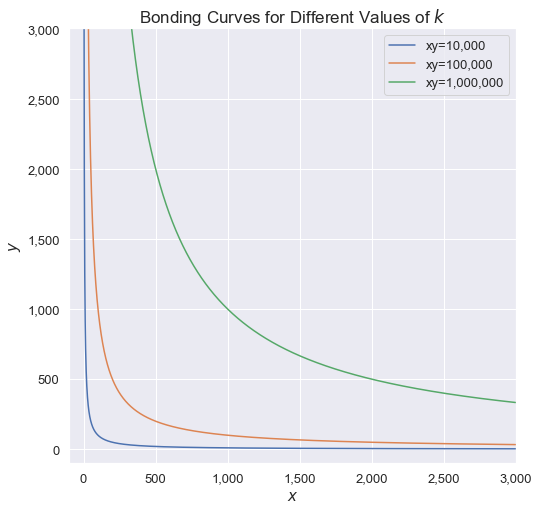

In [2]:
ks = [1e+4, 1e+5, 1e+6]
x = np.linspace(1, 3000, 3000)

fig, ax = plt.subplots(figsize=(8, 8))
for k in ks:
    y = k / x
    ax.plot(x, y, label=f'xy={k:,.0f}')
    
ax.set_title('Bonding Curves for Different Values of $k$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc='upper right')
ax.set_xlim(-100, 3000)
ax.set_ylim(-100, 3000)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

fig.savefig('./images/bonding_curves.png')
plt.show()

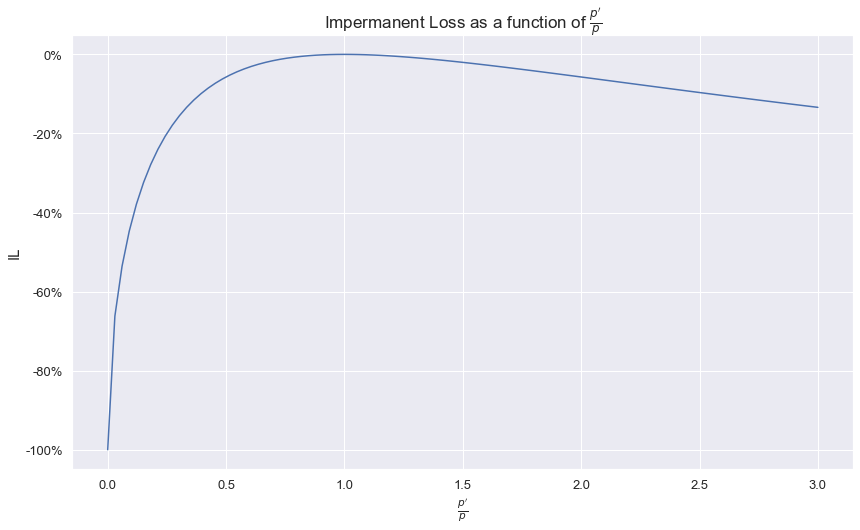

In [3]:
p_ratio = np.linspace(0, 3, 100)
il = 2 * np.sqrt(p_ratio) / (1 + p_ratio) - 1

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(p_ratio, il)
ax.set_xlabel("$\\frac{p'}{p}$")
ax.set_ylabel('IL')
ax.set_title("Impermanent Loss as a function of $\\frac{p'}{p}$")
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))

fig.savefig('./images/impermanent_loss.png')
plt.show()

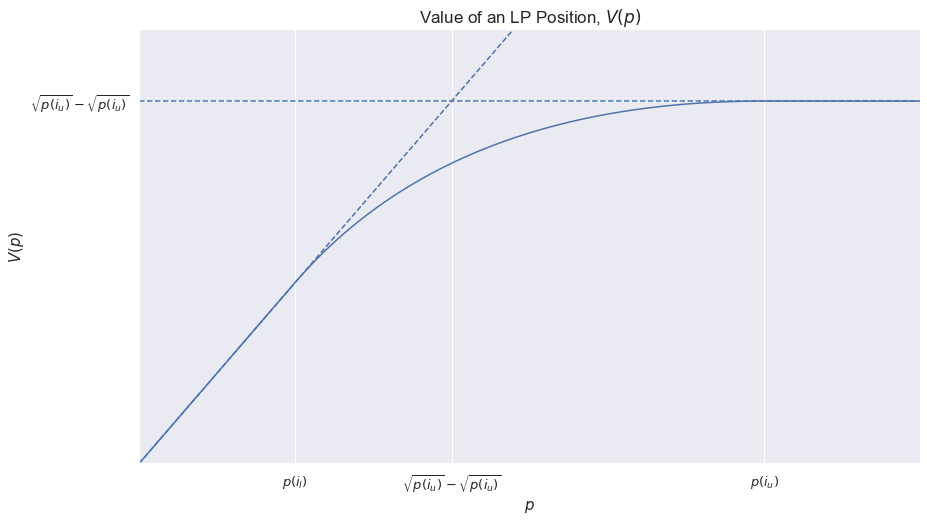

In [4]:
pl = 0.25
pu = 1
p = np.linspace(0, 1.25, 100)
dL=1

def value(p, pl, pu, dL=1):
    if p > pu:
        return dL * (np.sqrt(pu) - np.sqrt(pl))
    elif p < pl:
        return p * dL * (1 / np.sqrt(pl) - 1 / np.sqrt(pu))
    else:
        return dL * (2 * np.sqrt(p) - p / np.sqrt(pu) - np.sqrt(pl))

fig, ax = plt.subplots(figsize=(14, 8))

v = np.array([value(pi, pl, pu, dL=dL) for pi in p])
ax.plot(p, v)
ax.plot(p, dL * (np.sqrt(pu) - np.sqrt(pl)) * np.ones(len(p)), linestyle='--', color='b')
ax.plot(p, p * dL * (1 / np.sqrt(pl) - 1 / np.sqrt(pu)), linestyle='--', color='b')

ax.set_ylim(0, 0.6)
ax.set_xlim(0, 1.25)
ax.set_ylabel('$V(p)$')
ax.set_xlabel('$p$')
ax.yaxis.set_ticks([dL * (np.sqrt(pu) - np.sqrt(pl))], ['$\sqrt{p(i_u)} - \sqrt{p(i_u)}$'])
ax.xaxis.set_ticks([pl, dL * (np.sqrt(pu) - np.sqrt(pl)), pu], 
                      ['$p(i_l)$', '$\sqrt{p(i_u)} - \sqrt{p(i_u)}$', '$p(i_u)$'])
ax.set_title('Value of an LP Position, $V(p)$')

fig.savefig('./images/lp_position_value.png')
plt.show()

In [5]:
def pool_to_name(pool):
    token0, token1, fee = pool.split('-')
    fee = int(fee) / 1e+6
    
    return f'{token1}/{token0}, {fee:,.2%}'

In [6]:
pools = [
    'DAI-WETH-3000',
    'DAI-WETH-500',
    'USDC-WETH-3000',
    'USDC-WETH-500',
    'WETH-USDT-3000',
    'WETH-USDT-500',
    'WBTC-USDC-3000',
]

In [7]:
pool_returns = {}
for pool in pools:
    all_returns = pd.read_pickle(f'./eda_notebooks/saved-daily-returns/{pool}.pickle')
    
    bin_returns = defaultdict(list)
    for day, irrs in all_returns.items():
        for bin_pos, irr in irrs.items():
            bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
            bin_returns[bin_no].append(irr)
    
    pool_returns[pool] = bin_returns

In [8]:
def plot_pool_returns(pool_returns, ax=None, alpha=0.05):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    
    x_pos, x_labels, y, std_err = [], [], [], []
    for i in range(1, 23):
        x_pos.append(i)
        x_labels.append(f'{i - 11}$\sigma$')
        y.append(np.mean(pool_returns[i]))
        
        se = np.std(pool_returns[i]) / np.sqrt(len(pool_returns[i]))
        std_err.append(se)
    
    n = len(pool_returns[1])
    scale = stats.t.ppf(1 - alpha / 2, df=n - 1)
    y = np.array(y)
    std_err = np.array(std_err)

    ax.plot(x_pos, y)
    ax.fill_between(x_pos, y - scale * std_err, y + scale * std_err, alpha=0.25)

    ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
    ax.set_title(f'Daily Mean Returns Per Bin, with {1 - alpha:,.2%} Confidence Interval')
    ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

    return ax

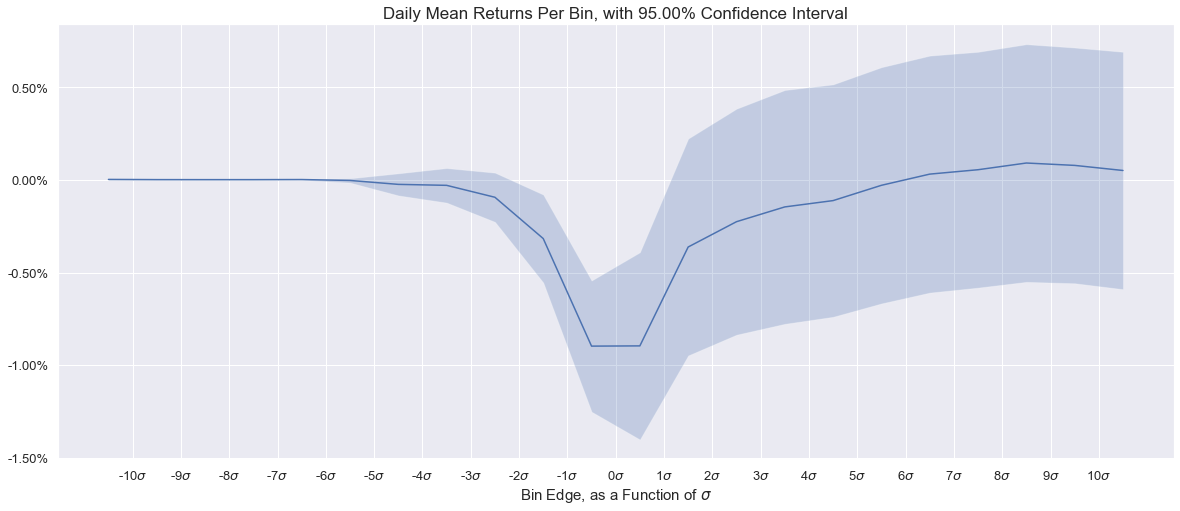

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_pool_returns(pool_returns['WETH-USDT-500'], ax=ax, alpha=0.05)

fig.savefig('./images/lp_returns_weth-usdt.png')
plt.show()

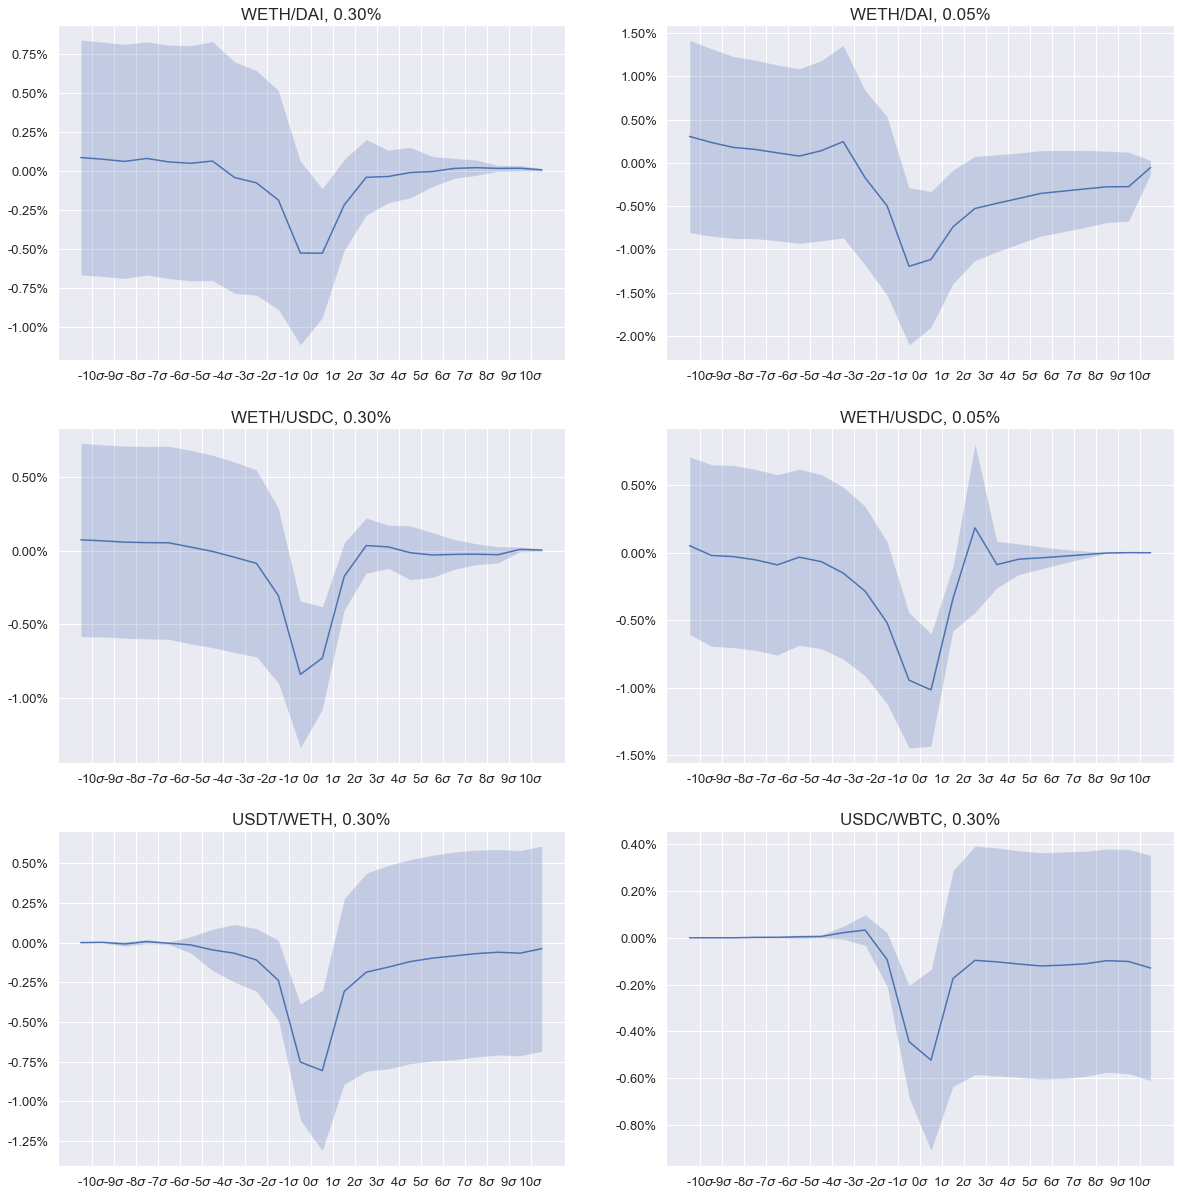

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(20, 7 * 3))

i = 0
alpha = 0.05
for pool in pools:
    if pool == 'WETH-USDT-500':
        continue
    plot_pool_returns(pool_returns[pool], ax=ax.flatten()[i], alpha=alpha)
    ax.flatten()[i].set_title(f'{pool_to_name(pool)}')
    ax.flatten()[i].set_xlabel(None)
    i += 1

fig.savefig('./images/lp_returns_all.png')
plt.show()

In [11]:
pool_mean_returns = {}
for pool in pools:
    mean_returns = []
    for i in range(1 + 7, 23 - 7):
        mean_returns.append(np.mean(pool_returns[pool][i]))
    pool_mean_returns[pool] = mean_returns

pool_mean_returns = pd.DataFrame(pool_mean_returns).T
print(pool_mean_returns.to_latex(header=False, float_format='{:0.2%}'.format))

\begin{tabular}{lrrrrrrrr}
\toprule
DAI-WETH-3000  & -0.04\% & -0.08\% & -0.19\% & -0.53\% & -0.53\% & -0.22\% & -0.04\% & -0.04\% \\
DAI-WETH-500   &  0.25\% & -0.17\% & -0.50\% & -1.19\% & -1.11\% & -0.74\% & -0.53\% & -0.47\% \\
USDC-WETH-3000 & -0.04\% & -0.09\% & -0.31\% & -0.84\% & -0.73\% & -0.17\% &  0.03\% &  0.03\% \\
USDC-WETH-500  & -0.15\% & -0.29\% & -0.52\% & -0.95\% & -1.02\% & -0.34\% &  0.18\% & -0.09\% \\
WETH-USDT-3000 & -0.07\% & -0.11\% & -0.24\% & -0.75\% & -0.81\% & -0.31\% & -0.19\% & -0.15\% \\
WETH-USDT-500  & -0.03\% & -0.09\% & -0.32\% & -0.90\% & -0.90\% & -0.36\% & -0.23\% & -0.15\% \\
WBTC-USDC-3000 &  0.02\% &  0.03\% & -0.09\% & -0.44\% & -0.52\% & -0.17\% & -0.10\% & -0.10\% \\
\bottomrule
\end{tabular}



In [12]:
header = (
    '$[-5\sigma, -4\sigma)$ & $[-4\sigma, -3\sigma)$ & $[-3\sigma, -4\sigma)$'
    '& $[-2\sigma, -4\sigma)$ $[-1\sigma, 0\sigma)$ & $[0\sigma, 1\sigma)$ & $[1\sigma, 2\sigma)$ '
    '& $[2\sigma, 3\sigma)$ & $[3\sigma, 4\sigma)$ & $[4\sigma, 5\sigma)$'
)
print(header)

$[-5\sigma, -4\sigma)$ & $[-4\sigma, -3\sigma)$ & $[-3\sigma, -4\sigma)$& $[-2\sigma, -4\sigma)$ $[-1\sigma, 0\sigma)$ & $[0\sigma, 1\sigma)$ & $[1\sigma, 2\sigma)$ & $[2\sigma, 3\sigma)$ & $[3\sigma, 4\sigma)$ & $[4\sigma, 5\sigma)$


In [13]:
pool_snapshots = {}
for pool in pools:
    pool_snapshots[pool] = pd.read_pickle(f'./eda_notebooks/saved-pools/{pool}.pickle')

In [14]:
def plot_liquidity_curves_on_days(pool_snapshots, pool_id, days, interval, 
                                  ax=None, hide_yticks=True):
    if ax is None:
        fig, ax = plt.subplots(1, len(days), figsize=(20, 6))
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])

    for i, day in enumerate(days):
        pool = pool_snapshots[pool_id][day]
        pool.plot_liquidity_curve(ax=ax[i], interval=interval)
        ax[i].axvline(pool.price, color='k', linewidth=0.5)
        ax[i].set_title(f'Liquidity Curve - {day[:10]}')
        
        if hide_yticks:
            ax[i].yaxis.set_ticklabels([])
        
        if pool.price > 1:
            ax[i].xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
        else:
            ax[i].xaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}'))

    y_min = min([ax[i].get_ylim()[0] for i in range(len(days))]) 
    y_max = max([ax[i].get_ylim()[1] for i in range(len(days))]) 
    for i in range(len(days)):
        ax[i].set_ylim(y_min, y_max)
        
    return ax

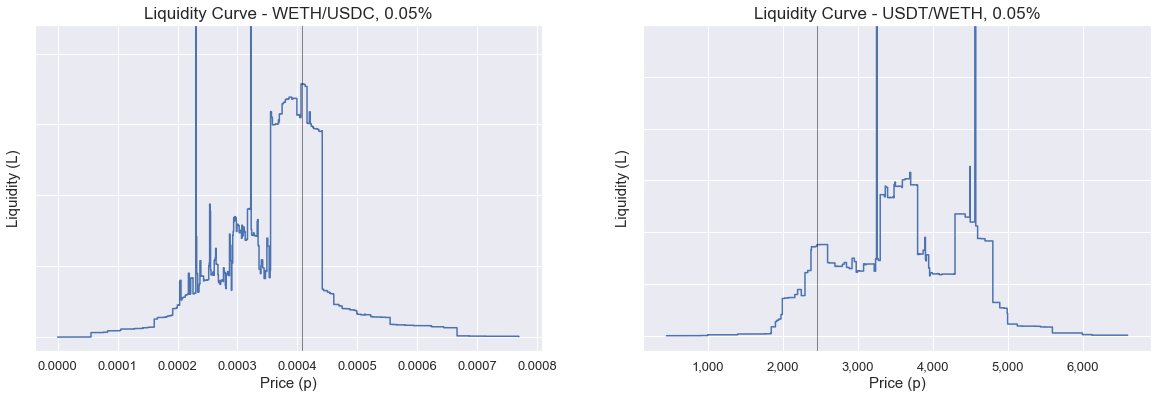

In [15]:
days = ['2022-01-27 00:00:00']
pool_ids = ['USDC-WETH-500', 'WETH-USDT-500']

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

_ = plot_liquidity_curves_on_days(pool_snapshots, pool_ids[0], days, 
                                  interval=(0, 0.0007), ax=ax[0])
ax[0].set_title(f'Liquidity Curve - {pool_to_name(pool_ids[0])}')
ax[0].set_ylim(-1, 22)  # set the y limit so that 0 matches on both graphs

_ = plot_liquidity_curves_on_days(pool_snapshots, pool_ids[1], days, 
                                  interval=(500, 6000), ax=ax[1])
ax[1].set_title(f'Liquidity Curve - {pool_to_name(pool_ids[1])}')
ax[1].set_ylim(-0.15, 3)  # set the y limit so that 0 matches on both graphs

fig.savefig('./images/example_liquidity_curves.png')
plt.show()

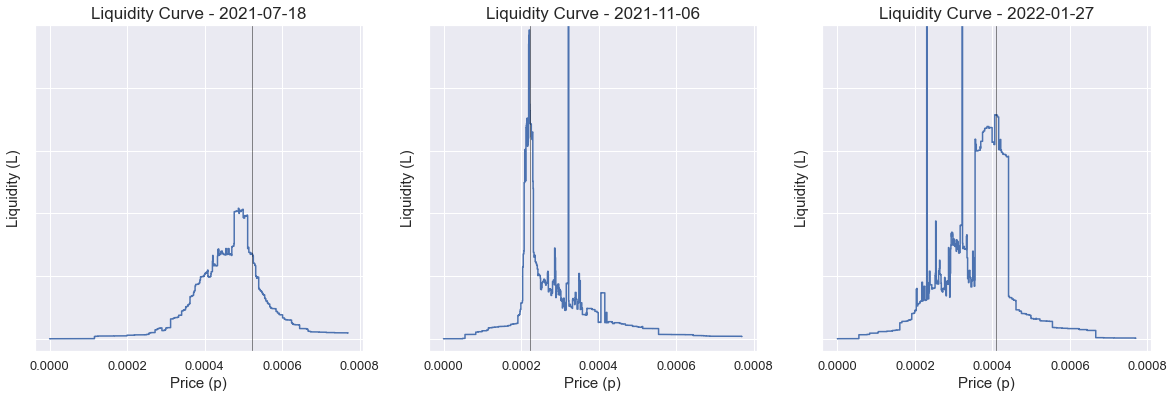

In [16]:
days = ['2021-07-18 00:00:00', '2021-11-06 00:00:00', '2022-01-27 00:00:00']
pool_id = 'USDC-WETH-500'

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
_ = plot_liquidity_curves_on_days(pool_snapshots, pool_id, days, 
                                  interval=(0, 0.0007), ax=ax)
for i in range(len(days)):
    ax[i].set_ylim(-1, 25)

fig.savefig('./images/example_liquidity_curves_weth-usdt.png')
plt.show()

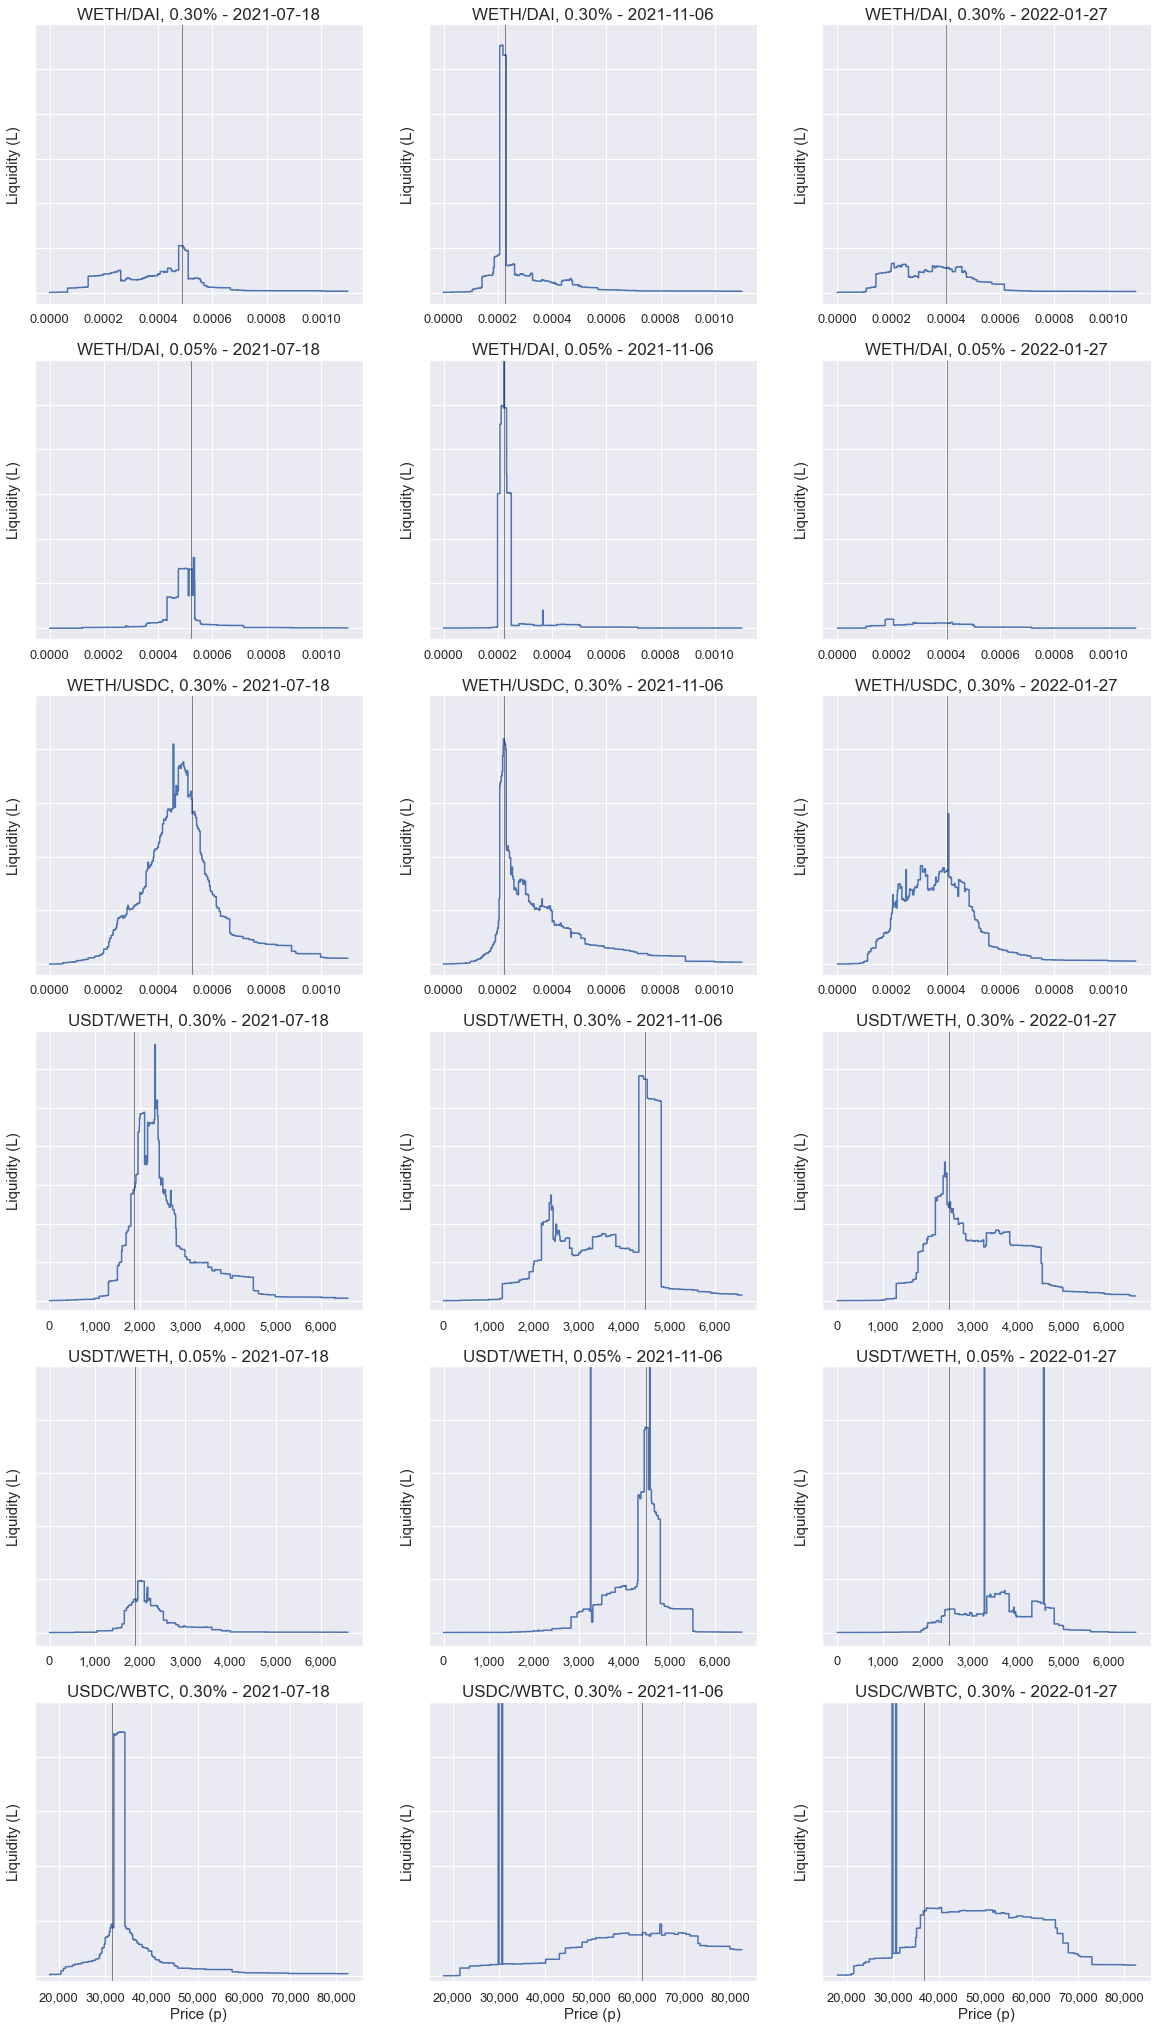

In [24]:
pool_intervals = {
    'DAI-WETH-3000': ((0, 0.001), (-0.05e+7, 1.2e+7)),
    'DAI-WETH-500': ((0, 0.001), (-0.05e+7, 1.2e+7)),
    'USDC-WETH-3000': ((0, 0.001), (-1, 25)),
    # 'USDC-WETH-500': ((0, 0.001), (-1, 25)),
    'WETH-USDT-3000': ((0, 6000), (-0.5, 14)),
    'WETH-USDT-500': ((0, 6000), (-0.5, 10)),
    'WBTC-USDC-3000': ((20000, 75000), (-1e+4, 50e+4)),
}
fig, ax = plt.subplots(len(pool_intervals), 3, 
                       figsize=(20, 6 * len(pool_intervals)))

days = ['2021-07-18 00:00:00', '2021-11-06 00:00:00', '2022-01-27 00:00:00']
for i, (pool_id, (x_interval, y_interval)) in enumerate(pool_intervals.items()):
    _ = plot_liquidity_curves_on_days(pool_snapshots, pool_id, days, 
                                      interval=x_interval, ax=ax[i])
    for j, day in enumerate(days):
        ax[i][j].set_title(f'{pool_to_name(pool_id)} - {day[:10]}')
        ax[i][j].set_ylim(*y_interval)
        if i < len(pool_intervals) - 1:
            ax[i][j].set_xlabel(None)
        
fig.savefig('./images/example_liquidity_curves_all.png')
plt.show()

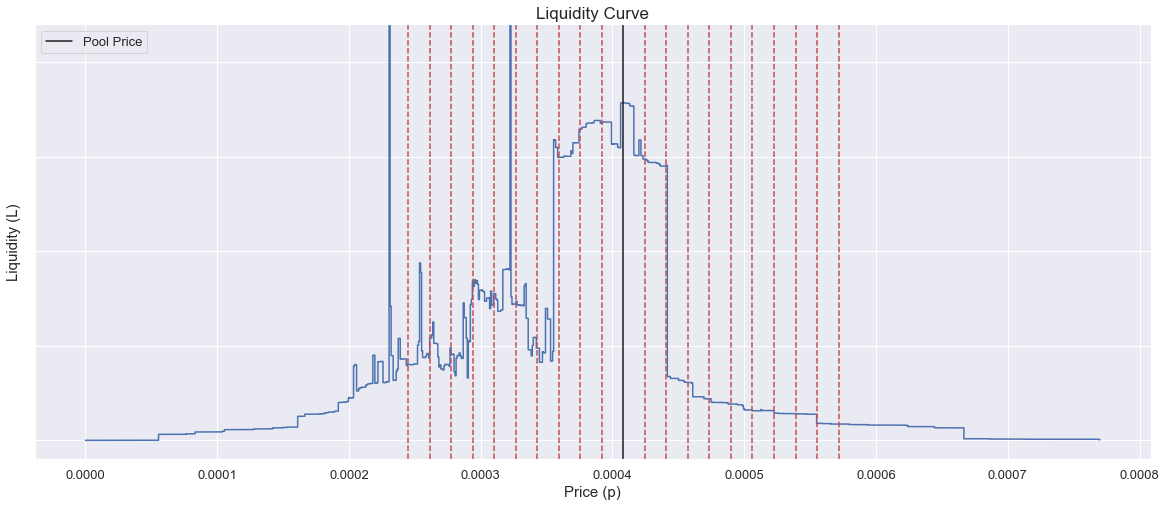

In [18]:
example_day = '2022-01-27 00:00:00'
pool = 'USDC-WETH-500'
sigma = 0.04
pool = pool_snapshots[pool][example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 0.0007), ax=ax)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}'))
ax.yaxis.set_ticklabels([])
ax.set_ylim(-1, 22)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

fig.savefig('./images/liquidity_bins_example.png')
plt.show()

In [19]:
data = pd.read_pickle('./data/pool_data_clean.pickle')

In [20]:
def load_minute_data(files):
    dfs = []
    for file in files:
        df = pd.read_csv(file, skiprows=1, index_col=1, parse_dates=['Date'])
        df.sort_index(inplace=True)
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['ref_value'] = df.loc[:, ['Open', 'High', 'Low', 'Close']].mean(axis=1)
    df = df.resample('1T').last()
    # Uniswap v3 was released in May 2021
    df.drop(df.index[df.index < '2021-05-01'], inplace=True)
    
    return df

In [21]:
# from https://www.cryptodatadownload.com/data/gemini/
eth_min_files = [
    './data/Gemini_ETHUSD_2021_1min.csv',
    './data/Gemini_ETHUSD_2022_1min.csv'
]
btc_min_files = [
    './data/Gemini_BTCUSD_2021_1min.csv',
    './data/Gemini_BTCUSD_2022_1min.csv'
]

eth_df = load_minute_data(eth_min_files)
btc_df = load_minute_data(btc_min_files)
ref_price_data = {
    'WETH': eth_df,
    'WBTC': btc_df
}

print('ETH')
eth_df.info()
print('\nBTC')
btc_df.info()

ETH
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426423 entries, 2021-05-01 00:00:00 to 2022-02-21 03:02:00
Freq: T
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  424650 non-null  float64
 1   Symbol          424650 non-null  object 
 2   Open            424650 non-null  float64
 3   High            424650 non-null  float64
 4   Low             424650 non-null  float64
 5   Close           424650 non-null  float64
 6   Volume          424650 non-null  float64
 7   ref_value       424650 non-null  float64
dtypes: float64(7), object(1)
memory usage: 29.3+ MB

BTC
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426423 entries, 2021-05-01 00:00:00 to 2022-02-21 03:02:00
Freq: T
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  424670 non-null  float64
 1   Symbol          424670 non-null

In [22]:
def plot_prices(swap_df, ref_price_df, ax=None):
    stable_coins = [
        'FRAX',
        'USDT',
        'USDC',
        'DAI'
    ]
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    
    token_col = swap_df.columns.get_loc('contract_ticker_symbol_token_0')
    asset_token = 0 if swap_df.iat[0, token_col] not in stable_coins else 1
    swap_df['pool_price'] = swap_df['price_tick_adjusted']
    if asset_token == 1:
        swap_df['pool_price'] = 1 / swap_df['pool_price']
    
    swaps = swap_df.set_index('swap_time', drop=True).loc[:, ['pool_price']]
    ax.plot(swaps, label='Pool Price', color='k', linewidth=0.5) 
        
    pool_fees = swap_df.iat[0, swap_df.columns.get_loc('pool_fee')] / 100000
    ref_price_df['ref_value_low'] = ref_price_df['ref_value'] * (1 - pool_fees)
    ref_price_df['ref_value_high'] = ref_price_df['ref_value'] / (1 - pool_fees)

    ax.plot(ref_price_df['ref_value'], label='Reference Value', color='r', linewidth=0.5)
    ax.fill_between(
        ref_price_df.index, 
        ref_price_df['ref_value_low'], 
        ref_price_df['ref_value_high'], 
        alpha=0.25, color='b'
    )
    ref_price_df.drop(['ref_value_low', 'ref_value_high'], axis=1, inplace=True)
    
    ax.legend(loc='upper right')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    return ax

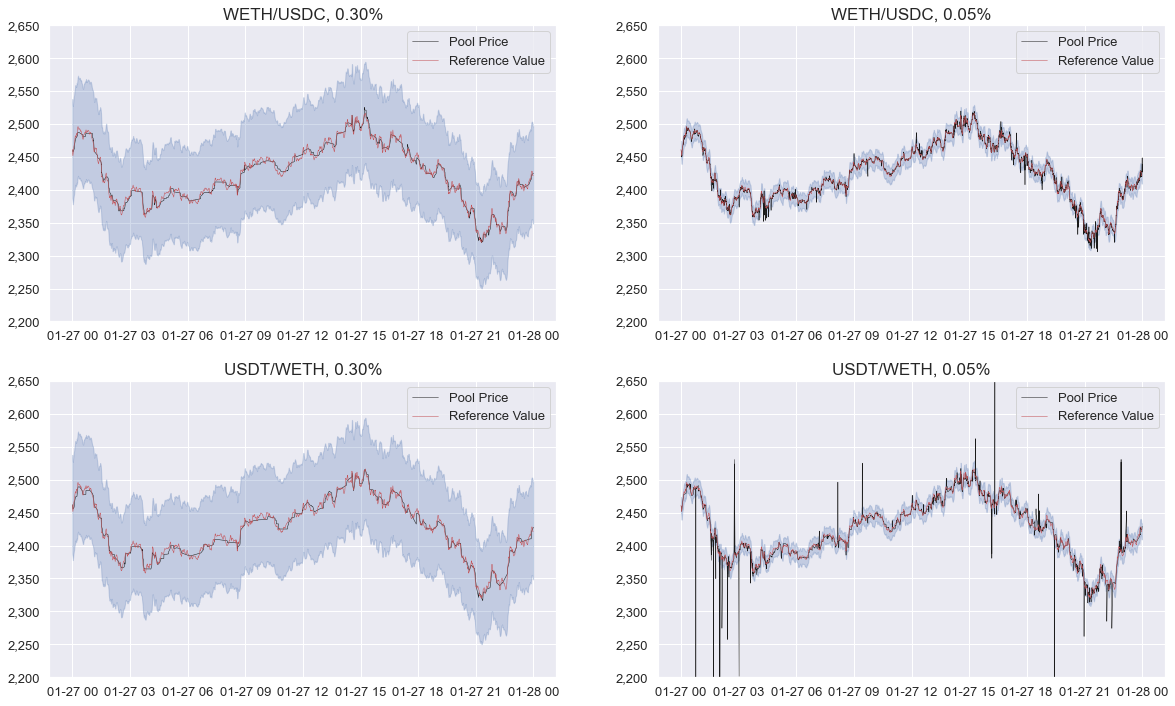

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

day = '2022-01-27'
day = pd.to_datetime(day)
        
selected_pools = [
    'USDC-WETH-3000',
    'USDC-WETH-500',
    'WETH-USDT-3000',
    'WETH-USDT-500',
]
                       
for i, pool in enumerate(selected_pools):
    swap_df = data[pool]['swaps'].copy()
    swap_df = swap_df.loc[swap_df['swap_time'].dt.date == day, :].copy()
    
    if 'WBTC' in pool:
        ref_price_df = btc_df
    else:
        ref_price_df = eth_df
    ref_price_df = ref_price_df.loc[ref_price_df.index.date == day, :].copy()
     
    plot_prices(swap_df, ref_price_df, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(pool_to_name(pool))
    ax.flatten()[i].set_ylim(2200, 2650)
    
fig.savefig('./images/actual_price_bounds.png')